In [118]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
from scipy.stats import probplot
import seaborn as sns
sns.set()
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise, Input, PReLU, Activation, Concatenate
from keras.models import load_model
from keras import backend as K
from sklearn import metrics

In [5]:
dframe_path = 'data/cabauw/processed-full-model.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

In [6]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]

In [227]:
# large-scale parameters, should be included
F1 = [
    'dewpoint', 'spec_hum', 'press', 'temp', 'air_dens', 
    'virtual_temp', 'rel_hum', 'rain', 'z', 'wind',
]

# radiation, no idea but probably should not include
F2 = [
    'co2flux', 'soilheat', 'netrad'
]

# fluxes, better if not included
F3 = [
    'H', 'LE',
]

# we must be desperate to use these to make it work
F4 = [
    'lval', #'zL', 'ustar'
]

features = F1 #+ F2 + F3 + F4

target = 'phi_m'

In [228]:
def make_index(dtimes, interval):
    # returns a tuple index_above, index_below
    # index_above[i] is the largest i
    # such that dtimes[index_above[i]] - dtimes[i] < interval
    # index_below[i] is the smallest i
    # such that dtimes[i] - dtimes[index_below[i]] < interval
    # dtimes must be already sorted!
    index_below, index_above = np.zeros(
        (2, len(dtimes)), dtype=np.int
    ) - 1
    
    for i, x in enumerate(dtimes):
        j = index_below[i - 1] if i > 0 else 0
        while x - dtimes[j] > interval:
            j += 1

        index_below[i] = j
        index_above[j] = i

    last_above = index_above[0]
    for i in range(len(dtimes)):
        if index_above[i] < 0:
            index_above[i] = last_above
        else:
            last_above = index_above[i]
    
    return index_above, index_below


def compute_trend(df, columns, interval=3600):
    df = df.sort_values('datetime')
    for z in df.z.unique():  
        sorted_df = df[df.z == z]
        index_above, index_below = make_index(sorted_df.datetime.values, interval)

        for col in columns:
            val_above = sorted_df.iloc[index_above][col].values
            val_below = sorted_df.iloc[index_below][col].values

            time_above = sorted_df.iloc[index_above].datetime.values
            time_below = sorted_df.iloc[index_below].datetime.values

            trend = 2 * interval * (val_above - val_below) / (time_above - time_below)

            df.loc[df.z == z, col + '_trend'] = trend

    return df, [col + '_trend' for col in columns]


use_trend = True
if use_trend:
    ddf, added_cols = compute_trend(df, [
        f.replace('_trend', '') for f in features
        if f != 'z' and 'trend' not in f
    ])
    features.extend(added_cols)
else:
    features = [f for f in features if 'trend' not in f]
    ddf = df


null_features = ddf[features].isnull().any(axis=1)
ddf = ddf[~null_features]

features = list(set(features))    
print('using features', features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


using features ['press_trend', 'temp', 'temp_trend', 'wind_trend', 'rain', 'air_dens_trend', 'spec_hum_trend', 'rel_hum_trend', 'rain_trend', 'virtual_temp', 'rel_hum', 'spec_hum', 'dewpoint', 'air_dens', 'virtual_temp_trend', 'dewpoint_trend', 'z', 'wind', 'press']


In [229]:
test_ds = np.random.choice(ddf.ds.unique(), 12, replace=False)
test_mask = ddf.ds.isin(test_ds)

sample = -100000

if sample > 0:
    tdf = ddf.sample(sample)
    train_x, train_y = tdf[features], tdf[target]
    tdf = ddf.sample(int(0.1 * sample))
    test_x, test_y = tdf[features], tdf[target]
else:
    train_x, train_y = ddf[~test_mask][features], ddf[~test_mask][target]
    test_x, test_y = ddf[test_mask][features], ddf[test_mask][target]

print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 1389395, testing with 95702


In [230]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [231]:
assert np.all(np.isfinite(norm_train_x))
assert np.all(np.isfinite(norm_train_y))

In [232]:
def denormalized_mse(y_true, y_pred):
    # model is trained with normalized data, but we want
    # mse on not normalized data to compare with MOST
    mse = K.mean(K.square(y_true - y_pred), axis=-1)
    return mse * std_y**2


def build_model(sizes, activation=lambda: PReLU()):
    # every element in sizes specifies a layer
    #   negative number: skip connection of -n layers
    #                    successive skips are aggregated
    #                    into a single layer
    #   0<n<1: dropout with pkeep=n
    #   >1 fully connected then prelu
    layers = [Input(shape=(len(features),))]
    i = 0
    while i < len(sizes):
        num = sizes[i]
        if num < 0:
            skip = [layers[-1]]
            while i < len(sizes) and sizes[i] < 0:
                skip.append(layers[sizes[i] - 1])
                i += 1
            layer = Concatenate()(skip)
            i -= 1
        elif num < 1:
            layer = Dropout(num)(layers[-1])
        else:
            layer = activation()(
                Dense(num)(
                    layers[-1]
                )
            )

        layers.append(layer)
        i += 1

    layers.append(Dense(1)(layers[-1]))

    opt = Adam(lr=0.001)
    model = Model(inputs=layers[0], outputs=layers[-1])
    model.compile(loss='mse', optimizer=opt, metrics=[denormalized_mse])
    return model


'''
model = build_model([
    512, 512, -2, 0.5,
    256, 256, -4, 0.5,
    128, 128, -4, 0.5,
    64, 64, -4, 0.5,
    32, 32, -4, 0.5,
    16, 16, -4,
    16, 16, -4,
    16, 16, -4,
    8, 8, -4,
    8, 8, -4,
    8, 8,
])
'''

model = build_model([
    1024, 0.5, 512, 0.5, 256, -2, -4, 0.5, 256, 0.5, 128, 64, 64, 32, 32, 16, 16, -4, 8, -8, 4, 2,
])

In [233]:
callbacks = [
    ReduceLROnPlateau(factor=0.5, verbose=1, min_lr=1e-6, patience=10),
    ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                    verbose=1, save_best_only=True),
    TensorBoard('dev/logs/', write_graph=False, write_grads=True),
    EarlyStopping(min_delta=0.0001, patience=25),
]

hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=4096, epochs=500,
    shuffle=True,
    callbacks=callbacks,
    validation_data=(norm_test_x, norm_test_y)
)

Train on 1389395 samples, validate on 95702 samples
Epoch 1/500
1388544/1389395 [============================>.] - ETA: 0s - loss: 0.5293 - denormalized_mse: 1.2167
Epoch 00001: val_loss improved from inf to 0.39874, saving model to dev/models/weights-w.0001-0.3987.hdf5
1389395/1389395 [==============================] - 53s 38us/step - loss: 0.5293 - denormalized_mse: 1.2165 - val_loss: 0.3987 - val_denormalized_mse: 0.9165
Epoch 2/500
1388544/1389395 [============================>.] - ETA: 0s - loss: 0.4603 - denormalized_mse: 1.0580
Epoch 00002: val_loss improved from 0.39874 to 0.38976, saving model to dev/models/weights-w.0002-0.3898.hdf5
1389395/1389395 [==============================] - 38s 27us/step - loss: 0.4603 - denormalized_mse: 1.0579 - val_loss: 0.3898 - val_denormalized_mse: 0.8958
Epoch 3/500
1388544/1389395 [============================>.] - ETA: 0s - loss: 0.4519 - denormalized_mse: 1.0388
Epoch 00003: val_loss improved from 0.38976 to 0.38481, saving model to dev/mod

KeyboardInterrupt: 

In [ ]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

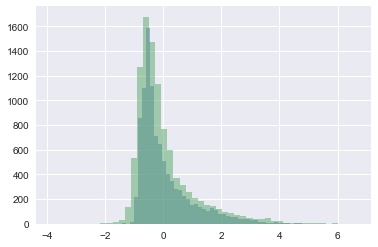

In [146]:
_ = plt.hist(y_pred, alpha=0.5, bins=50)
_ = plt.hist(norm_test_y, alpha=0.5, bins=50)
#plt.yscale('symlog', linthreshy=100)

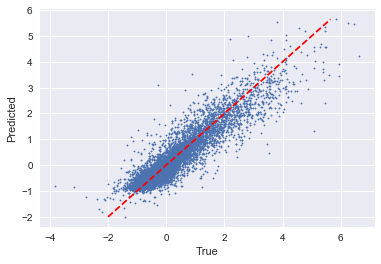

Explained variance 0.851166222959615
Mean absolute error 0.394006072763766
Mean squared error 0.35487932147252055
Median absolute error 0.2607791556581662
R2 score 0.8510689994076982
Mean absolute percent error [133.38542]


In [147]:
best_model = load_model('dev/models/weights-w.0155-0.1551.hdf5',
                        custom_objects={'denormalized_mse': denormalized_mse})
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

plot_preds(y_pred, norm_test_y)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)

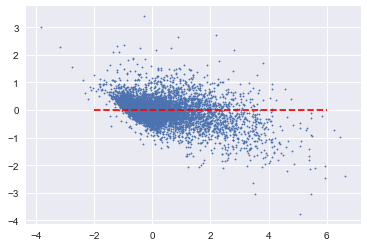

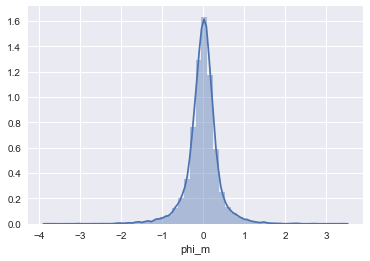

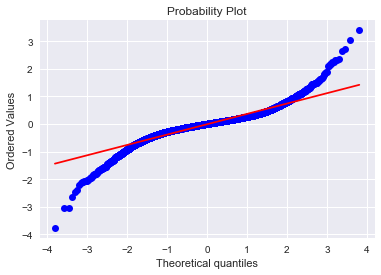

count    10000.000000
mean        -0.010061
std          0.393667
min         -3.762702
25%         -0.173985
50%          0.004670
75%          0.170849
max          3.395111
Name: phi_m, dtype: float64

In [148]:
residuals = y_pred.reshape(-1) - norm_test_y
plt.scatter(norm_test_y, residuals, s=2)
plt.plot([-2, 6], [0, 0], 'r--'); plt.show()
sns.distplot(residuals); plt.show()
probplot(residuals, plot=plt); plt.show()
residuals.describe().T